Non-Sampling vs Sampling
- [PCE vs MC](#PCE-vs-MC)
    - [Polynomial Chaos](#Polynomial-Chaos)
    - [Monte Carlo](#Monte-Carlo)
    - [Comparison](#Comparison)
        - [Computing time](#Computing-time)
        - [Mean value at $t=1$, $t=0.5$](#Mean-value-at-$t=1$,-$t=0.5$)

Sampling vs Sampling
- [Poly vs NN](#Poly-vs-NN)
    - [NN](#NN)
    - [Polynomial Regression](#Polynomial-Regression)

Non-Sampling + Sampling
- [Stochastic collocation method](#Stochastic-collocation-method) 


- [Further Discussion](#Further-Discussion)
    - [NN2](#NN2)
        - [One step method](#One-step-method)
        - [Split step method](#Split-step-method)

In [1]:
# !pip install tensorflow --upgrade

In [2]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.random import set_seed
from math import factorial
from scipy.stats import norm
from scipy.integrate import odeint
import numpy.polynomial.hermite_e as H 
from sklearn.preprocessing import StandardScaler
import dolfin as fn
from numpy.polynomial.legendre import leggauss

import matplotlib.pyplot as plt

# PCE vs MC

$$ \frac{dy(t)}{dt} = -\lambda y, \ \  y(0)=1 $$
$$ y(t) = e^{-\lambda t} $$
$$QoI = y(0.5)$$
$\Lambda = (-\infty, \infty)$, $\mathcal{D}=(0,\infty)$

## Polynomial Chaos

In [3]:
start_def = time.time()

def Phi(n):
    #define H_n
    coeffs = [0]*(n+1)
    coeffs[n] = 1
    return coeffs

def inner2_herm(n):       ###return the denominator when computing $k_i$
    return factorial(n)

def product3_herm(i,j,l):
    #compute \Phi_i*\Phi_j*\Phi_l
    return lambda x: H.hermeval(x, H.hermemul(H.hermemul(Phi(i),Phi(j)),Phi(l))) 

def inner3_herm(P,i,j,l):
    #compute <\Phi_i\Phi_j\Phi_l>
    
    #Set up Gauss-Hermite quadrature, weighting function is exp^{-x^2}
    m=(P+1)**2
    x, w=H.hermegauss(m)        
    inner=sum([product3_herm(i,j,l)(x[idx]) * w[idx] for idx in range(m)])         
    
    return inner/np.sqrt(2*np.pi)   #because of the weight

time_def = time.time() - start_def

In [4]:
start_prep = time.time()

P=4
ki_herm = [0,1]+[0]*(P-1)
Inner3_herm = np.zeros((P+1,P+1,P+1)) #store all inner3_herm values
Inner2_herm = np.zeros(P+1)

for i in range(P+1):
    for j in range(P+1):
        for l in range(P+1):
            Inner3_herm[i,j,l] = inner3_herm(P,i,j,l)

for i in range(P+1):
    Inner2_herm[i] = inner2_herm(i)
            
time_prep = time.time() - start_prep

In [5]:
start_ode = time.time()

def ode_system_herm(y, t, P):   
    #P indicates the highest degree
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(Inner3_herm[i,j,l]*ki_herm[i]*y[j] for j in range(P+1)) for i in range(P+1)))/Inner2_herm[l]
    return dydt
            
time_ode = time.time() - start_ode

In [6]:
start_solveode = time.time()

sol_herm = odeint(ode_system_herm, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, )) 

time_solveode = time.time() - start_solveode

In [7]:
time_all = time_def + time_prep + time_ode + time_solveode

## Monte Carlo

In [8]:
start_ode_mc = time.time()

def ode(y,t,nsample,k):
    '''
    Build the ode system
    '''
    dydt = np.zeros(nsample)
    for i in range(nsample):
        dydt[i] = -k[i]*y[i]
    return dydt

time_def_mc = time.time() - start_ode_mc

In [9]:
nsample = np.array([10, 100, 1000, 10000, 100000])
time_solveode_mc = np.zeros(len(nsample))
start_solveode_mc = np.zeros(len(nsample))
mean_mc_1 = np.zeros(len(nsample))
mean_mc_05 = np.zeros(len(nsample))

for i in range(len(nsample)):
    k = norm.rvs(loc=0, scale=1, size=nsample[i], random_state=12345)
    start_solveode_mc[i] = time.time()

    sol_mc = odeint(ode, [1.0]*nsample[i], np.linspace(0,1,101),args=(nsample[i],k))  #t:np.linspace(0,1,101)
    mean_mc_1[i] = np.mean(sol_mc[100,:])
    mean_mc_05[i] = np.mean(sol_mc[50,:])

    time_solveode_mc[i] = time.time() - start_solveode_mc[i]

time_all_mc = time_def_mc + time_solveode_mc

## Comparison

### Computing time

In [10]:
### MC
print(time_solveode_mc)
### PCE
print(time_solveode)     

[8.71419907e-04 7.48610497e-03 7.96811581e-02 7.63551235e-01
 8.56107402e+00]
0.016486406326293945


### Mean value at $t=1$, $t=0.5$
    
    
#### Sample size = 1000 for MC

In [11]:
## t = 1
mean_pc_1 = sol_herm[:,0][100]   #mean value using pc at t=1
mean_exact_1 = np.e**(1/2)

## t = 0.5
mean_pc_05 = sol_herm[:,0][50]   #mean value using pc at t=0.5
mean_exact_05 = np.e**(1/8)

print(mean_pc_1)
print(mean_mc_1)
print(mean_exact_1)

print()

print(mean_pc_05)
print(mean_mc_05)
print(mean_exact_05)

1.6486794979185284
[0.80759128 1.64191001 1.58804937 1.67483542 1.65016842]
1.6487212707001282

1.1331484337155744
[0.84243543 1.12379462 1.12573071 1.13969688 1.13387003]
1.1331484530668263


# Poly vs NN

Finite difference:
$$
\frac{y_{i+1} - y_i}{\Delta t} = -\lambda y_i
$$
so
$$
y_{i+1} = -\lambda\Delta t y_i + y_i = (1-\lambda\Delta t)y_i
$$

Define $n := \frac{0.5}{\Delta t}$, then
$$
\hat{Q}(\lambda)=y(0.5) = y_n = (1-\lambda\Delta t)^n y_0 = (1-\lambda\Delta t)^n
$$

## NN

In [15]:
#######################################
#define the activation function
def rbf(x):
    return tf.math.exp(-x**2)

#######################################
#define the derivative of the activation function
def d_rbf(x):
    return tf.gradients(rbf,x)

#######################a################
#we couldn't use “tf_d_leaky_relu_6” as an activation function if we wanted to 
#because tensorflow doesn't know how to calculate the gradients of that function.
def rbf_grad(op, grad):
    x = op.inputs[0]
    n_gr = d_rbf(x)    #defining the gradient.
    return grad * n_gr

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+2))
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name, "PyFuncStateless": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def tf_rbf(x,name=None):
    with tf.name_scope(name, "rbf", [x]) as name:
        y = py_func(rbf,   #forward pass function
                    [x],
                    [tf.float32],
                    name=name,
                    grad= rbf_grad) #the function that overrides gradient
        y[0].set_shape(x.get_shape())     #when using with the code, it is used to specify the rank of the input.
    return y[0]

In [102]:
np.random.seed(12345)
size = 100
delta_t = 0.01
n = int(0.5/delta_t)
### Original data ###
lam_in = np.random.normal(0, 1, size)
y_exact = np.array([np.exp(-i*0.5) for i in lam_in])
y_out = np.array([(1-i*delta_t)**n for i in lam_in])
### After feature scaling ###
scaler = StandardScaler()
data_trans = scaler.fit_transform(lam_in.reshape(-1,1))

In [103]:
num_neuron = 5
tf.random.set_seed(12345)
model_ode = tf.keras.Sequential()
model_ode.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_ode.add(tf.keras.layers.Dense(1))

model_ode.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_ode.fit(data_trans[:,0],y_out, epochs=1500, verbose=0)

In [104]:
preds_ode = []
for j in data_trans[:,0]:
    preds_ode.append(model_ode.predict([j]))

preds_ode_shaped = tf.reshape(tf.constant(np.array(preds_ode)),len(preds_ode))
mse_fd_nn = tf.keras.losses.MSE(y_exact,preds_ode_shaped).numpy()
mse_fd_nn

0.0002756652

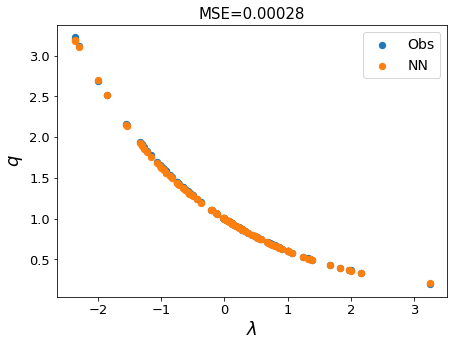

In [105]:
fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$\lambda$",fontsize=18)
plt.ylabel("$q$",fontsize=18)
plt.title("MSE=%.5f"%(mse_fd_nn),fontsize=15)
plt.scatter(lam_in, y_out, s=40, label='Obs')
plt.scatter(lam_in, preds_ode_shaped,s=40, label='NN')
plt.legend(prop={'size': 14});
# fig.savefig("images/comp_fd_nn.png")

<font color=red>
Feature scaling:

- When predicting value is not in the training data set, the unscaled output will be off. Since the meany, vary only describe the property of the training y values but not for any y values. So it is hard to scale it back!!!

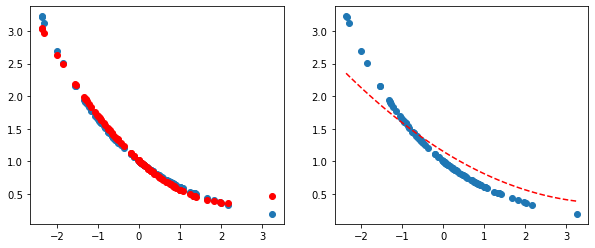

In [106]:
from scipy.optimize import curve_fit

# define the true objective function
def objective(x, a, b, c):
	return a + b * x + c * x**2 

plt.figure(figsize=(10,4))
#### Predict on the same training set #####
plt.subplot(121)
plt.scatter(lam_in, y_out)
popt, _ = curve_fit(objective, data_trans[:,0], y_out)
a, b, c = popt
y_scale = objective(data_trans[:,0], a, b, c)
plt.scatter(lam_in, y_scale, color='red');
#### Predict on different x values #####
plt.subplot(122)
plt.scatter(lam_in, y_out)
popt, _ = curve_fit(objective, data_trans[:,0], y_out)
a, b, c = popt
x_line = np.linspace(min(lam_in), max(lam_in), 50)
scaler_cf = StandardScaler()
x_line_trans = scaler_cf.fit_transform(x_line.reshape(-1,1))
y_scale = objective(x_line_trans, a, b, c)
plt.plot(x_line, y_scale, '--', color='red')

## Polynomial Regression
`np.polyfit`

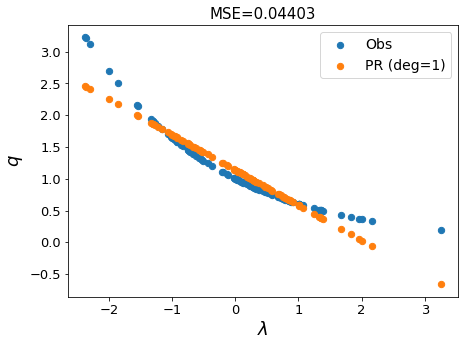

In [107]:
######## With feature scaling ############3
mymodel1 = np.poly1d(np.polyfit(data_trans[:,0], y_out, 1))
preds_fd_pr1 = mymodel1(data_trans[:,0])
mse_fd_pr1 = tf.keras.losses.MSE(y_exact,preds_fd_pr1).numpy()

fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$\lambda$",fontsize=18)
plt.ylabel("$q$",fontsize=18)
plt.title("MSE=%.5f"%(mse_fd_pr1),fontsize=15)
plt.scatter(lam_in, y_out, s=40, label='Obs')
plt.scatter(lam_in, preds_fd_pr1,s=40,label='PR (deg=1)')
plt.legend(prop={'size': 14});
# fig.savefig("images/comp_fd_pr1.png")

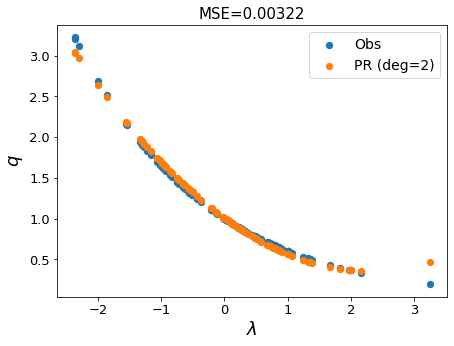

In [108]:
########## With feature scaling #############
mymodel2 = np.poly1d(np.polyfit(data_trans[:,0], y_out, 2))
preds_fd_pr2 = mymodel2(data_trans[:,0])
mse_fd_pr2 = tf.keras.losses.MSE(y_exact,preds_fd_pr2).numpy()

fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$\lambda$",fontsize=18)
plt.ylabel("$q$",fontsize=18)
plt.title("MSE=%.5f"%(mse_fd_pr2),fontsize=15)
plt.scatter(lam_in, y_out, s=40, label='Obs')
plt.scatter(lam_in, preds_fd_pr2,s=40, label='PR (deg=2)')
plt.legend(prop={'size': 14});
# fig.savefig("images/comp_fd_pr2.png")

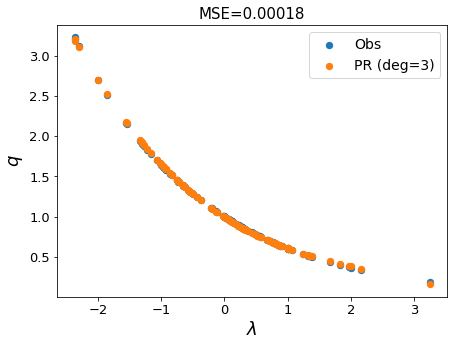

In [109]:
########## With feature scaling #############
mymodel3 = np.poly1d(np.polyfit(data_trans[:,0], y_out, 3))
preds_fd_pr3 = mymodel3(data_trans[:,0])
mse_fd_pr3 = tf.keras.losses.MSE(y_exact,preds_fd_pr3).numpy()

fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$\lambda$",fontsize=18)
plt.ylabel("$q$",fontsize=18)
plt.title("MSE=%.5f"%(mse_fd_pr3),fontsize=15)
plt.scatter(lam_in, y_out, s=40, label='Obs')
plt.scatter(lam_in, preds_fd_pr3,s=40, label='PR (deg=3)')
plt.legend(prop={'size': 14});
# fig.savefig("images/comp_fd_pr3.png")

# Stochastic collocation method

\begin{align*}
- \nabla\cdot(A\nabla u) &= (e^{\lambda_1}\lambda_1^2\pi^2 + e^{\lambda_2}\lambda_2^2\pi^2)u \\
u &= 0 \, \text{ on } \Gamma_0 \,\text{(   Left edge)}\\
(A\nabla u)\cdot n &= -e^{\lambda_2}\lambda_2\pi \sin\lambda_1\pi x\sin \lambda_2\pi y \, \text{ on } \Gamma_1  \, \text{(   Top edge)}\\
(A\nabla u)\cdot n &= e^{\lambda_2}\lambda_2\pi \sin\lambda_1\pi x\sin \lambda_2\pi y \, \text{ on } \Gamma_2  \,\text{(   Bottom edge)}\\
(A\nabla u)\cdot n &= e^{\lambda_1}\lambda_1\pi \cos\lambda_1\pi x\cos \lambda_2\pi y \, \text{ on } \Gamma_3  \,\text{(   Right edge)}\\
\end{align*}

where 
$$ A = \begin{bmatrix} e^{\lambda_1} & 0 \\ 0 & e^{\lambda_2} \end{bmatrix} $$
and $(x,y)\in\Omega = [0,1]\times [0,1]$, $(\lambda_1,\lambda_2)\in\Lambda=[0,1]\times [0,1]$

<font color = red>**Exact solution:**
$$ u(x,y;\lambda_1,\lambda_2) = \sin \lambda_1\pi x \cos \lambda_2 \pi y$$
</font>
QoI is:
$$
Q(\lambda_1,\lambda_2) = u(0.5,0.5;\lambda_1,\lambda_2)
$$
----

$\lambda_1,\lambda_2\sim U(0,1)$

**In theory:**
\begin{align*}
\overline{u}(x,y;\lambda_1,\lambda_2) &= \int_0^1 \int_0^1\sin \lambda_1\pi x \cos \lambda_2 \pi y \, d\lambda_1d\lambda_2\\
&= \int_0^1\sin \lambda_1\pi x\, d\lambda_1 \int_0^1 \cos \lambda_2 \pi y\, d\lambda_2\\
&= \left(-\frac{1}{\pi x}\cos(\lambda_1\pi x)\biggr\rvert_0^1 \right)\left(\frac{1}{\pi y}\sin(\lambda_2\pi y)\biggr\rvert_0^1 \right)\\
&= \left(-\frac{\cos(\pi x) - 1}{\pi x}\right)\frac{\sin(\pi y)}{\pi y}
\end{align*}


QoI is:
$$
Q(\lambda_1,\lambda_2) = u(0.5,0.5;\lambda_1,\lambda_2)
$$
so
<font color=red>
$$
\overline{Q} = \frac{4}{\pi^2}
$$
</font>

--- 

$\lambda = (\lambda_1, \lambda_2)$, $x=(x,y)$, $L_k$ is Lagrange polynomial

$$
\hat{u}(\lambda, x) = \sum_{k=1}^M u(\lambda_k, x)L_k(\lambda)
$$

**In Practice:**

**Step 1:**
- Use numpy.polynomial.legendre.leggauss
    - Quadrature point of $\lambda_1:$ $\left(\xi_i^{(1)}\right)_{i=1}^M$ $\in [-1,1]$
    - Quadrature point of $\lambda_2:$ $\left(\xi_j^{(2)}\right)_{j=1}^N$ $\in [-1,1]$
- Then the quadrature points in $[0,1]$ are
    - $\lambda_1:$ $\frac{1}{2}\xi_i^{(1)}+\frac{1}{2}$, $i=1,2,\cdots,M$
    - $\lambda_2:$ $\frac{1}{2}\xi_j^{(2)}+\frac{1}{2}$, $j=1,2,\cdots,N$

Notice 
$$
L_{ij}(\lambda_1,\lambda_2) = L_i^{(1)}(\lambda_1) L_j^{(2)}(\lambda_2)
$$

where $L_i^{(1)}$ corresponds to $\frac{1}{2}\xi_i^{(1)}+\frac{1}{2}$, $L_j^{(2)}$ corresponds to $\frac{1}{2}\xi_j^{(2)}+\frac{1}{2}$


**Step 2:**
- For $\lambda_1=\frac{1}{2}\xi_i^{(1)}+\frac{1}{2}$, $\lambda_2=\frac{1}{2}\xi_j^{(2)}+\frac{1}{2}$, use FEM to solve for $u$ evaluated at $x=0.5, y=0.5$. Use notation $u_{ij}$ to indicate the value

\begin{align*}
\mathbb{E}[\hat{u}] &= \sum_{i=1,j=1}^{M,N} u_{ij} \int_{\Lambda} L_{ij}(\lambda) \rho(\lambda) \, d\lambda\\
&\approx \sum_{i=1,j=1}^{M,N} u_{ij} \int_0^1 L_i^{(1)}(\lambda_1)\, d\lambda_1 \int_0^1 L_j^{(2)}(\lambda_2)\, d\lambda_2\\
&\approx \sum_{i=1,j=1}^{M,N} u_{ij} \left( \frac{1}{2}\sum_{k=1}^M w_k L_i^{(1)}\left(\frac{1}{2}\xi_k^{(1)} + \frac{1}{2} \right) \right) \left( \frac{1}{2}\sum_{l=1}^N w_l L_j^{(2)}\left(\frac{1}{2}\xi_l^{(2)} + \frac{1}{2} \right) \right)\\
&= \sum_{i=1,j=1}^{M,N} u_{ij} \frac{w_i}{2} \frac{w_j}{2}\\
&= \frac{1}{4} \sum_{i=1,j=1}^{M,N} u_{ij} w_i w_j
\end{align*}

**Step3:**

Compare with $\frac{4}{\pi^2}$

----

<font color=red>**Extra reference**</font>

Gauss–Legendre quadrature [-1,1]

$$
\int_a^b f(x)\, dx \approx \frac{b-a}{2}\sum_{i=1}^n w_i f\left(\frac{b-a}{2}\xi_i + \frac{a+b}{2} \right)
$$

$a=0, b=1$

$$
\int_0^1 f(x)\, dx \approx \frac{1}{2}\sum_{i=1}^n w_i f\left(\frac{1}{2}\xi_i + \frac{1}{2} \right)
$$

Our input $\lambda$ is in a 2-dim space, and 
$$
L_k(\lambda) = L_k^{(1)}(\lambda_1)L_k^{(2)}(\lambda_2)
$$
For example, we have

| $\lambda_1$ | $\lambda_2$ | $f$ |
| --- | --- | --- |
| $x_1$ | $y_1$ | $f_1$ |
| $x_2$ | $y_2$ | $f_2$ |
| $x_3$ | $y_3$ | $f_3$ |

Then 
$$
L_1(\lambda_1, \lambda_2) = \frac{(\lambda_1 - x_2)(\lambda_1 - x_3)(\lambda_2 - y_2)(\lambda_2 - y_3)}{(x_1 - x_2)(x_1 - x_3)(y_1 - y_2)(y_1 - y_3)} = L_1^{(1)}(\lambda_1)L_1^{(2)}(\lambda_2)
$$
where $L_1^{(1)}$ is the 1-d Lagrange wrt point $x_1$, $L_1^{(2)}$ is the 1-d Lagrange wrt point $y_1$

In [95]:
x11, x22 = 0.5, 0.5

In [96]:
def QoI_FEM(lam1,lam2,gridx,gridy,p):
    mesh = fn.UnitSquareMesh(gridx, gridy)
    V = fn.FunctionSpace(mesh, "Lagrange", p)

    # Define diffusion tensor (here, just a scalar function) and parameters
    A = fn.Expression((('exp(lam1)','a'),
                ('a','exp(lam2)')), a = fn.Constant(0.0), lam1 = lam1, lam2 = lam2, degree=3) 

    u_exact = fn.Expression("sin(lam1*pi*x[0])*cos(lam2*pi*x[1])", lam1 = lam1, lam2 = lam2, degree=2+p)

    # Define the mix of Neumann and Dirichlet BCs
    class LeftBoundary(fn.SubDomain):
        def inside(self, x, on_boundary):
            return (x[0] < fn.DOLFIN_EPS)
    class RightBoundary(fn.SubDomain):
        def inside(self, x, on_boundary):
            return (x[0] > 1.0 - fn.DOLFIN_EPS)
    class TopBoundary(fn.SubDomain):
        def inside(self, x, on_boundary):
            return (x[1] > 1.0 - fn.DOLFIN_EPS)
    class BottomBoundary(fn.SubDomain):
        def inside(self, x, on_boundary):
            return (x[1] < fn.DOLFIN_EPS)

    # Create a mesh function (mf) assigning an unsigned integer ('uint')
    # to each edge (which is a "Facet" in 2D)
    mf = fn.MeshFunction('size_t', mesh, 1)
    mf.set_all(0) # initialize the function to be zero
    # Setup the boundary classes that use Neumann boundary conditions
    NTB = TopBoundary() # instatiate
    NTB.mark(mf, 1) # set all values of the mf to be 1 on this boundary
    NBB = BottomBoundary()
    NBB.mark(mf, 2) # set all values of the mf to be 2 on this boundary
    NRB = RightBoundary()
    NRB.mark(mf, 3)

    # Define Dirichlet boundary conditions
    Gamma_0 = fn.DirichletBC(V, u_exact, LeftBoundary())
    bcs = [Gamma_0]

    # Define data necessary to approximate exact solution
    f = ( fn.exp(lam1)*(lam1*fn.pi)**2 + fn.exp(lam2)*(lam2*fn.pi)**2 ) * u_exact
    g1 = fn.Expression("-exp(lam2)*lam2*pi*sin(lam1*pi*x[0])*sin(lam2*pi*x[1])", lam1=lam1, lam2=lam2, degree=2+p)    #pointing outward unit normal vector, pointing upaward (0,1)
    g2 = fn.Expression("exp(lam2)*lam2*pi*sin(lam1*pi*x[0])*sin(lam2*pi*x[1])", lam1=lam1, lam2=lam2, degree=2+p)     #pointing downward (0,1)
    g3 = fn.Expression("exp(lam1)*lam1*pi*cos(lam1*pi*x[0])*cos(lam2*pi*x[1])", lam1=lam1, lam2=lam2, degree=2+p)

    fn.ds = fn.ds(subdomain_data=mf)
    # Define variational problem
    u = fn.TrialFunction(V)
    v = fn.TestFunction(V)
    a = fn.inner(A*fn.grad(u), fn.grad(v))*fn.dx
    L = f*v*fn.dx + g1*v*fn.ds(1) + g2*v*fn.ds(2) + g3*v*fn.ds(3)  #note the 1, 2 and 3 correspond to the mf

    # Compute solution
    u = fn.Function(V)
    fn.solve(a == L, u, bcs)

    return u(x11,x22)

def exactQ(x,y):
    return (1-np.cos(np.pi*x))*np.sin(np.pi*y)/(np.pi**2*x*y)

In [97]:
##### Generate uij_M*_N*.dat ######
M, N = 5, 5
x1,w1 = leggauss(M)
x2,w2 = leggauss(N)

uij = np.zeros((M,N))
for i in range(M):
    for j in range(N):
        uij[i,j] = QoI_FEM((1+x1[i])/2,(1+x2[j])/2,10,10,2)
        
# np.savetxt('uij_M%d_N%d_x%.1f_y%.1f.dat'%(M,N,x11,x22), uij)

In [98]:
##### From stochastic collocation method #####

# M, N = 10, 10
# x1,w1 = leggauss(M)
# x2,w2 = leggauss(N)
# uij = np.loadtxt('uij_M%d_N%d.dat'%(M,N))

sol = 0
for i in range(M):
    for j in range(N):
        sol += w1[i]*w2[j]*uij[i,j]
sol /= 4

print('Stochastic Collocation Estimate: ', sol)
print('Exact value: '+ ' '*20, exactQ(x11,x22))  #4/np.pi**2

Stochastic Collocation Estimate:  0.4052952283963789
Exact value:                      0.40528473456935105


# Further Discussion

<font color=red> Scaling, number of layers, print out the MSE every step, how to piecewise
    
- x_train, x_plt should have similar property. For StandardScaler(), var \& mean need to be similar
    

In [25]:
def model(x):
    if x<=1:
        return 15*x+10
    elif x<=7:
        return x**3-12*x**2+36*x
    elif x<=10:
        return 15/np.pi*np.sin(np.pi*(x-7))+7
    else:
        return -30*np.sqrt(x-9)+37

In [26]:
np.random.seed(12345)
x_syn = np.random.uniform(0,15,100)
y_exact = np.array([model(i) for i in x_syn])
y_syn = y_exact+np.random.normal(0,1,len(x_syn))

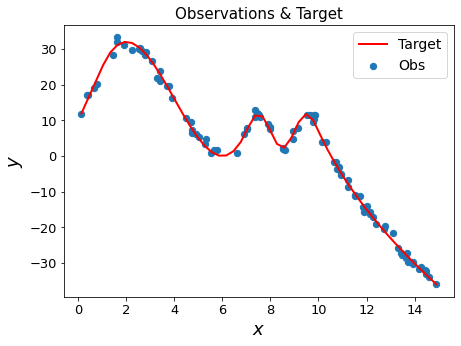

In [27]:
fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
plt.title('Observations & Target',fontsize=15)
x_plt = np.linspace(min(x_syn),max(x_syn),50)
y_plt = [model(i) for i in x_plt]
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.plot(x_plt, y_plt, color='red', linewidth=2, label='Target')
plt.legend(prop={'size': 14});
# fig.savefig("images/comp_target.png")

## NN2

In [28]:
scaler_syn = StandardScaler()
syndata_trans = scaler_syn.fit_transform(x_syn.reshape(-1,1))

### One step method

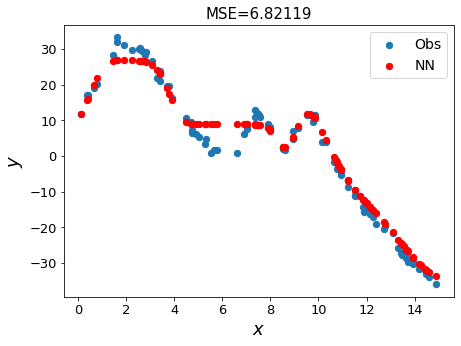

In [114]:
############### With Feature Scaling ###############
num_neuron = 5
tf.random.set_seed(12345)
model_syn_all = tf.keras.Sequential()
model_syn_all.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_syn_all.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
# model_syn_all.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
# model_syn_all.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_syn_all.add(tf.keras.layers.Dense(1))

model_syn_all.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_syn_all.fit(syndata_trans[:,0],y_syn, epochs=1000, verbose=0)

fig = plt.figure(figsize=(7,5))
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred = []
for j in syndata_trans[:,0]:
    y_pred.append(model_syn_all.predict([j]))
y_pred_shaped = tf.reshape(tf.constant(np.array(y_pred)),len(y_pred))
error0 = tf.keras.losses.MSE(y_syn,y_pred_shaped).numpy()
plt.title("MSE=%.5f"%(error0),fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred_shaped, s=40, color='red',label="NN")
plt.legend(prop={'size': 14});
# fig.savefig("images/comp_nn_1step.png")

### Split step method

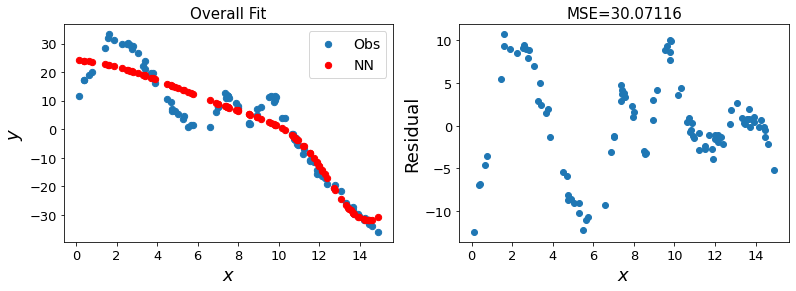

In [115]:
## Step 1
num_neuron = 5
tf.random.set_seed(12345)
model_nn1 = tf.keras.Sequential()
model_nn1.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_nn1.add(tf.keras.layers.Dense(1))

model_nn1.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_nn1.fit(syndata_trans[:,0],y_syn, epochs=1000, verbose=0)

fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred1 = []
for j in syndata_trans[:,0]:
    y_pred1.append(model_nn1.predict([j]))
y_pred1_shaped = tf.reshape(tf.constant(np.array(y_pred1)),len(y_pred1))
plt.title("Overall Fit",fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred1_shaped, s=40, color='red',label="NN")
plt.legend(prop={'size': 14});
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
mse1 = tf.keras.losses.MSE(y_syn,y_pred1_shaped).numpy()
plt.title("MSE=%.5f"%(mse1),fontsize=15)
plt.scatter(x_syn, y_syn-y_pred1_shaped);
# fig.savefig("images/comp_nn_step1.png");

y = w_1\sigma(.) + w_2\sigma(.) + residual_1
residual_1 = w_3\sigma(.) + w_4\sigma(.)  + residual_2

y = w_1\sigma(.) + w_2\sigma(.) + w_3\sigma(.) + w_4\sigma(.)  + residual_2

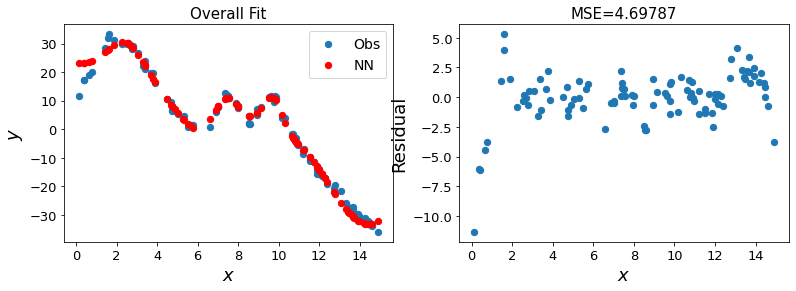

In [116]:
## Step 2

tf.random.set_seed(12345)
model_nn2 = tf.keras.Sequential()
model_nn2.add(tf.keras.layers.Dense(5,activation=rbf))
model_nn2.add(tf.keras.layers.Dense(1))

error1 = y_syn - y_pred1_shaped
scaler_syn2 = StandardScaler()

model_nn2.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_nn2.fit(syndata_trans[:,0],error1, epochs=1000, verbose=0)

fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred2 = []
for j in syndata_trans[:,0]:
    y_pred2.append(model_nn2.predict([j]))
y_pred2_shaped = tf.reshape(tf.constant(np.array(y_pred2)),len(y_pred2))
plt.title("Overall Fit",fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred1_shaped+y_pred2_shaped, s=40, color='red',label="NN")
plt.legend(prop={'size': 14});
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
mse2 = tf.keras.losses.MSE(y_syn,y_pred1_shaped+y_pred2_shaped).numpy()
plt.title("MSE=%.5f"%(mse2),fontsize=15)
plt.scatter(x_syn, y_syn-y_pred1_shaped-y_pred2_shaped, s=40);
# fig.savefig("images/comp_nn_step2.png");

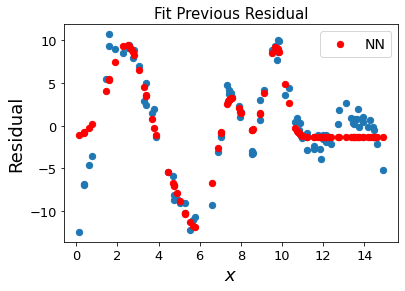

In [32]:
fig = plt.figure()
# plt.subplot(133)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
plt.title("Fit Previous Residual",fontsize=15)
plt.scatter(x_syn, error1, s=40)
plt.scatter(x_syn, y_pred2_shaped, s=40, color='red',label="NN")
plt.legend(prop={'size': 14});
# fig.savefig("images/comp_nn_res2.png");

<font color=red>**I tried to use 'relu', but not much improvement. Maybe not enough training data??**

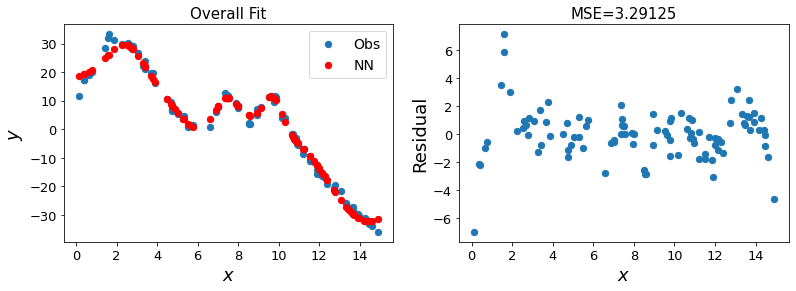

In [117]:
## Step 3

tf.random.set_seed(12345)
model_nn3 = tf.keras.Sequential()
model_nn3.add(tf.keras.layers.Dense(5,activation=rbf))
model_nn3.add(tf.keras.layers.Dense(1))

error2 = y_syn - y_pred1_shaped - y_pred2_shaped
scaler_syn3 = StandardScaler()

model_nn3.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_nn3.fit(syndata_trans[:,0],error2, epochs=1000, verbose=0)

fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred3 = []
for j in syndata_trans[:,0]:
    y_pred3.append(model_nn3.predict([j]))
y_pred3_shaped = tf.reshape(tf.constant(np.array(y_pred3)),len(y_pred3))
plt.title("Overall Fit",fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred1_shaped+y_pred2_shaped+y_pred3_shaped, s=40, color='red',label="NN")
plt.legend(prop={'size': 14});
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
mse3 = tf.keras.losses.MSE(y_syn,y_pred1_shaped+y_pred2_shaped+y_pred3_shaped).numpy()
plt.title("MSE=%.5f"%(mse3),fontsize=15)
plt.scatter(x_syn, y_syn-y_pred1_shaped-y_pred2_shaped-y_pred3_shaped,s=40);
# fig.savefig("images/comp_nn_step3.png");

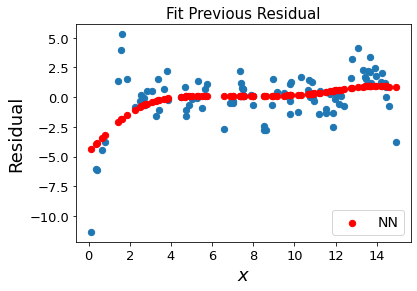

In [34]:
fig = plt.figure()
# plt.subplot(133)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
plt.title("Fit Previous Residual",fontsize=15)
plt.scatter(x_syn, error2, s=40)
plt.scatter(x_syn, y_pred3_shaped,s=40,color='red',label="NN")
plt.legend(prop={'size': 14});
# fig.savefig("images/comp_nn_res3.png");

## 3 "1-5-1" = "1-15-1"

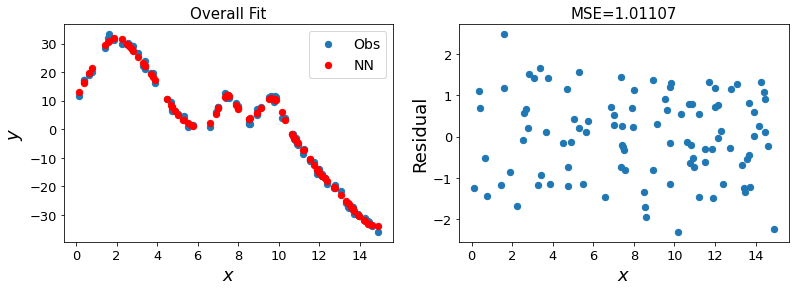

In [118]:
## Step 1

num_neuron = 15
tf.random.set_seed(12345)
model_nn11 = tf.keras.Sequential()
model_nn11.add(tf.keras.layers.Dense(num_neuron,activation=rbf))
model_nn11.add(tf.keras.layers.Dense(1))

model_nn11.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))
model_nn11.fit(syndata_trans[:,0],y_syn, epochs=5000, verbose=0)

fig = plt.figure(figsize=(13,4))
plt.subplot(121)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)
y_pred11 = []
for j in syndata_trans[:,0]:
    y_pred11.append(model_nn11.predict([j]))
y_pred11_shaped = tf.reshape(tf.constant(np.array(y_pred11)),len(y_pred11))
plt.title("Overall Fit",fontsize=15)
plt.scatter(x_syn, y_syn, s=40, label='Obs')
plt.scatter(x_syn, y_pred11_shaped,s=40,color='red',label="NN")
plt.legend(prop={'size': 14});
plt.subplot(122)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("Residual",fontsize=18)
mse11 = tf.keras.losses.MSE(y_syn,y_pred11_shaped).numpy()
plt.title("MSE=%.5f"%(mse11),fontsize=15)
plt.scatter(x_syn, y_syn-y_pred11_shaped,s=40);
fig.savefig("images/comp_nn_step11.png");

https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re